## Electric Energy Load Demand Forecasting for Rural Area

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
# function to read load data 
def data_reader(file_name):
    data = pd.read_excel(file_name, parse_dates=True, index_col='Time', usecols=range(2))
    return data

# function to read weather data
def weather_reader(file_name):
    weather = pd.read_excel(file_name, parse_dates=True, index_col='Time measured')
    return weather

# function for concatenating load data and weather data for training
def concat_data(file_name_load, file_name_weather):
    train_data = pd.concat([file_name_load, file_name_weather], axis=1)
    return train_data

In [5]:
# Load weather & load time-series data
load_data = data_reader('Index_Bjønntjønn_2014_2018.xlsx')
weather_data = weather_reader('bo_temp_2014_2018.xlsx')
weather_data = weather_data.interpolate()

# Concatenate
dataframe = concat_data(load_data, weather_data)

# Renaming columns for easier interpreting:
dataframe = dataframe.rename(columns={"Total":"Load","Middeltemperatur i 2m høyde (TM)": "Temperature"})

In [6]:
dataframe.head()

,Load,Temperature
2014-01-01 01:00:00,227.0,2.9
2014-01-01 02:00:00,216.0,3.0
2014-01-01 03:00:00,197.0,3.0
2014-01-01 04:00:00,198.0,3.1
2014-01-01 05:00:00,198.0,3.5


In [7]:
def show_plots(data, time_start, time_end=None):
    # Ploting time-series data with different time ranges
    fig, ax = plt.subplots(figsize=(7,4.5))
    ax2 = ax.twinx()
    data['Load'].loc[time_start:time_end].plot(c='seagreen', label='Load', ax=ax)
    if time_end is None:
        data['Temperature'].loc[time_start].plot(c='darkorange', label='Temperature', ax=ax2)
    else:
        data['Temperature'].loc[time_start:time_end].plot(c='darkorange', label='Temperature', ax=ax2)
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax.set_ylabel('Load', fontsize=12, fontweight='bold', color='seagreen')
    ax2.set_ylabel('Temperature', fontsize=12, fontweight='bold', color='darkorange')
    fig.tight_layout()
    plt.show()
    return

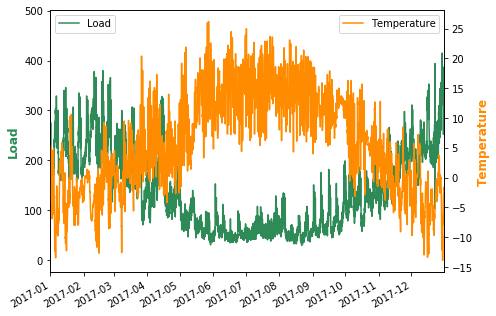

In [8]:
# Time-series for 2018
show_plots(dataframe, '2017')

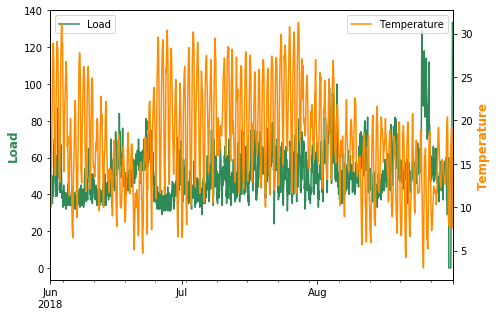

In [9]:
# Time-series for June to August 2018
show_plots(dataframe, '2018-06', '2018-08')

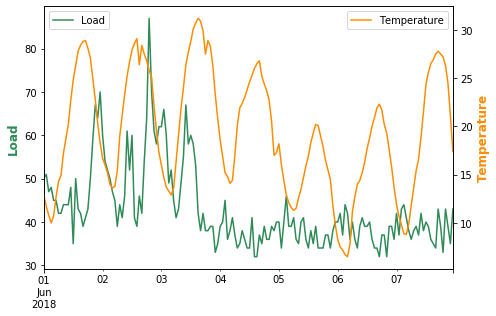

In [10]:
show_plots(dataframe, '2018-06-01', '2018-06-07')

In [11]:
# Hard-coding holiday dates
holiday_dates = {
    # 2014 year
    '2014-Jan-1st': ('2014-01-01', None),  # single day
    '2014-Easter': ('2014-04-14', '2014-04-21'),  # date range
    '2014-May-1st': ('2014-05-01', None),
    '2014-Pentecost': ('2014-06-07', '2014-06-10'),
    '2014-Xmas': ('2014-12-21', '2014-12-31'),
    # 2015 year
    '2015-Jan-1st': ('2015-01-01', None),
    '2015-Easter': ('2015-03-30', '2015-04-06'),
    '2015-May-1st': ('2015-05-01', None),  # Friday
    '2015-Ascension': ('2015-05-14', None),
    '2015-Pentecost': ('2014-05-24', '2014-05-25'),
    '2015-Xmas': ('2015-12-23', '2015-12-31'),
    # 2016 year
    '2016-Jan-1st': ('2016-01-01', None),
    '2016-Easter': ('2016-03-21', '2016-03-28'),
    '2016-May-1st': ('2015-05-01', None),  # Sunday
    '2016-Ascension': ('2016-05-05', None),
    '2016-Pentecost': ('2016-05-16', '2016-05-17'),
    '2016-Xmas': ('2016-12-26', '2016-12-31'),
    # 2017 year
    '2017-Jan-1st': ('2017-01-01', None),
    '2017-Easter': ('2017-04-10', '2017-04-17'),
    '2017-May-1st': ('2017-05-01', None),  # Monday
    '2017-May-17th': ('2017-05-17', None),  # Wednesday
    '2017-Ascension': ('2017-05-25', None),
    '2017-Pentecost': ('2017-06-05', None),
    '2017-Xmas': ('2017-12-25', '2017-12-31'),
    # 2018 year
    '2018-Jan-1st': ('2018-01-01', None),
    '2018-Easter': ('2018-03-26', '2018-04-02'),
    '2018-May-1st': ('2018-05-01', None),  # Tuesday
    '2018-Ascension': ('2017-05-10', None),  # Thursday
    '2018-May-17th': ('2017-05-17', None),
    '2018-Pentecost': ('2018-05-21', None),
    '2018-Xmas': ('2018-12-24', '2018-12-31')}

In [12]:
def engineer_features(dataframe, holiday_dates, columns, time_lags=24, 
                      steps_ahead=1, drop_nan_rows=True):
    """Engineering features
    
    Load data features column names with underscore (i.e. Load_1h, Load_2h, etc.) 
    represent time-lags (t-1, t-2, ...), while those with plus sign (i.e. Load+1h, 
    Load+2h, etc.) represent future time-steps (t+1, t+2, ...); column with name
    Load+0h represents current load at time instant t. 
    
    Parameters
    ----------
    dataframe: pandas dataframe
        original dataframe with time-series data
    holiday_dates: dictionary
        dictionary with tuples specifying local holiday dates or date-ranges
    columns: list
        list of column names from the dataframe which are used for the 
        features engineering (i.e. time-lags)
    time_lags: int
        number of time lags for use with feature engineering
    steps_ahead: int
        number of steps ahead for multi-step forecasting (steps_ahead=1
        means single-step ahead forecasting)
    drop_nan_rows: bool
        True/False indicator to drop rows with NaN values

    Returns
    -------
    dataframe: pandas dataframe 
        dataframe augmented with additional features
    """
    
    # Make a copy of the original dataframe
    data = dataframe[columns].copy()
            
    # Features engineering
    for col in data.columns:
        for i in range(1, time_lags+1):
            # Shift data by lag of 1 to time_lags (default: 24) hours
            data[col+'_{:d}h'.format(i)] = data[col].shift(periods=i)  # time-lag
        data[col+'_diff'] = data[col].diff()  # first-difference
        data[col+'_week'] = data[col].shift(periods=24*7)  # previous week
    
    # Hour-of-day indicators with cyclical transform
    dayhour_ind = data.index.hour
    data['hr_sin'] = np.sin(dayhour_ind*(2.*np.pi/24))
    data['hr_cos'] = np.cos(dayhour_ind*(2.*np.pi/24))
    
    # Day-of-week indicators with cyclical transform
    weekday_ind = data.index.weekday
    data['week_sin'] = np.sin(weekday_ind*(2.*np.pi/7))
    data['week_cos'] = np.cos(weekday_ind*(2.*np.pi/7))

    # Weekend as a binary indicator
    data['weekend'] = np.asarray([0 if ind <= 4 else 1 for ind in weekday_ind])

    # Month indicators with cyclical transform
    month_ind = data.index.month
    data['mnth_sin'] = np.sin((month_ind-1)*(2.*np.pi/12))
    data['mnth_cos'] = np.cos((month_ind-1)*(2.*np.pi/12))
    
    # Holidays as a binary indicator
    data['holidays'] = 0
    for holiday, date in holiday_dates.items():
        if date[1] is None:
            # Single day
            data.loc[date[0], 'holidays'] = 1
        else:
            # Date range
            data.loc[date[0]:date[1], 'holidays'] = 1
    
    # Forecast horizont
    if steps_ahead == 1:
        # Single-step forecasting
        data['Load+0h'] = data['Load'].values
    else:
        # Multi-step forecasting
        for i in range(steps_ahead):
            data['Load'+'+{:d}h'.format(i)] = data['Load'].shift(-i)
    del data['Load']
    
    if drop_nan_rows:
        # Drop rows with NaN values
        data.dropna(inplace=True)
        
    return data

In [13]:
def train_test_split(dataframe, start_date, window_days=100, train_percent=80.,
                     return_arrays=False):
    """Train and test data set split
    
    Parameters
    ----------
    dataframe: pandas dataframe
        dataframe augmented with additional features
    start_date: string
        starting date of the time-series 
    window_days: int
        size of the data window in days
    train_percent: float
        percentage of the data window size to use for creating the 
        training data set (the rest is used for testing)
    return_arrays: bool
        True/False indicator which defines the type of output; if 
        True function returns numpy arrays; if False it returns
        pandas dataframes
    
    Returns
    -------
    X_train: dataframe or array
        training data 2D array of input features
    y_train: dataframe or array
        training data array of output values
    X_test: dataframe or array
        testing/validation data 2D array of input features
    y_test: dataframe or array
        testing/validation data array of output values
    """
    data = dataframe.copy()
    if window_days*24 > data.values.shape[0]:
        raise ValueError('Variable window_days has too large value: {}*24h = {} > {}, \
            which is more than there is data!'.format(window_days, window_days*24, 
                                                      data.values.shape[0]))
    
    # Split dataframe into X, y
    columns = data.columns.values
    outputs = [col_name for col_name in columns if 'Load+' in col_name]
    inputs = [col_name for col_name in columns if col_name not in outputs]
    # inputs (features)
    X = data[inputs]
    # outputs
    y = data[outputs]
    
    # Training period
    train_percent = train_percent/100.
    st = pd.to_datetime(start_date)  # start date
    et = st + dt.timedelta(days=int(train_percent*window_days))  # end date
    X_train = X.loc[st:et]
    y_train = y.loc[st:et]
    
    # Testing / Validation period
    sv = et 
    ev = sv + dt.timedelta(days=int((1-train_percent)*window_days)+1)
    X_test = X.loc[sv:ev]
    y_test = y.loc[sv:ev]
        
    if return_arrays:
        # Returning numpy arrays
        return X_train.values, y_train.values, X_test.values, y_test.values
    else:
        # Returning pandas dataframes
        return X_train, y_train, X_test, y_test

In [14]:
STEPS_AHEAD = 24
# 24-hours ahead forecasting (steps_ahead=24)
data_features = engineer_features(dataframe, holiday_dates, 
                                  columns=['Load', 'Temperature'], 
                                  steps_ahead=STEPS_AHEAD)

In [15]:
START_DATE = '2014-01-09'
WINDOW_SIZE_DAYS = 400
# Split dataset into training and test/validation sets
X_train, y_train, X_test, y_test = train_test_split(data_features, start_date=START_DATE, 
                                                    window_days=WINDOW_SIZE_DAYS)

In [16]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7681, 61) (7681, 24)
(1921, 61) (1921, 24)


In [17]:
# Scale and transform input data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [18]:
BATCH_SIZE = 256
EPOCHS = 400
WAIT = 50  # patience
LR = 1e-3  # learning rate
# Feed-forward and fixed funnel-shaped deep ANN
# tf.keras functional API
input_layer = keras.layers.Input(shape=X_train_sc.shape[1:])
x = keras.layers.Dense(units=1024, activation='relu')(input_layer)
x = keras.layers.Dropout(0.2)(x)  # regularization
x = keras.layers.Dense(units=512, activation='relu')(x)
x = keras.layers.Dense(units=512, activation='relu')(x)
x = keras.layers.Dropout(0.1)(x)  # regularization
x = keras.layers.Dense(units=256, activation='relu')(x)
output_layer = keras.layers.Dense(STEPS_AHEAD)(x)
model = keras.models.Model(inputs=input_layer, outputs=output_layer)
adam = keras.optimizers.Adam(learning_rate=LR, decay=LR/EPOCHS)
model.compile(loss='mae', optimizer=adam, metrics=['mae', 'mape'])
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, 
                                           patience=WAIT, verbose=1,
                                           restore_best_weights=True)
history = model.fit(X_train_sc, y_train.values, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    validation_data=(X_test_sc, y_test.values),
                    callbacks=[early_stop], shuffle=True, verbose=0,
                    use_multiprocessing=True)

Restoring model weights from the end of the best epoch.
Epoch 00141: early stopping


MAE val_loss at final epoch is 17.46, while min. val_loss is 17.15.


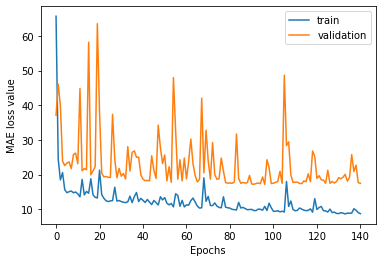

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']
print('MAE val_loss at final epoch is {:.2f}, while min. val_loss is {:.2f}.'
      .format(val_loss[-1], min(val_loss)))
plt.plot(loss, label='train')
plt.plot(val_loss, label='validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('MAE loss value')
plt.show()

In [20]:
def prepare_test_data(dataframe, start_date, window_days, test_size=1):
    """ Prepare test data
    
    Arguments
    ---------
    dataframe: pandas dataframe
        original dataframe with features
    start_date: string
        starting date for the time-series previously used
        in creating the train and test/validation data sets
    window_days: int
        size of the data window in days previously used
        in creating the train and test/validation data sets
    test_size: int
        number of time-steps (hours) for walk-forward testing
        
    Returns
    -------
    X_new: numpy array
        walk-forward testing data set as numpy array
    """
    data = dataframe.copy()
    date_test_start = pd.to_datetime(start_date) + dt.timedelta(days=window_days)
    date_test_end = date_test_start + dt.timedelta(hours=test_size)
    
    columns = data.columns.values
    outputs = [col_name for col_name in columns if 'Load+' in col_name]
    inputs = [col_name for col_name in columns if col_name not in outputs]
    
    if test_size == 1:
        X_new = data[inputs].loc[date_test_start].values.reshape(1,-1)
    else:
        X_new = data[inputs].loc[date_test_start:date_test_end].values[:-1]

    return X_new

In [21]:
TEST_SIZE = 12  # walk-forward for 12 hours
X_new = prepare_test_data(data_features, START_DATE, WINDOW_SIZE_DAYS, TEST_SIZE)

In [22]:
X_new_sc = scaler.transform(X_new)

In [23]:
# Predict on new values
y_pred = model.predict(X_new_sc)

In [24]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred)/y_true))*100.

MAPE = 5.58 (%)


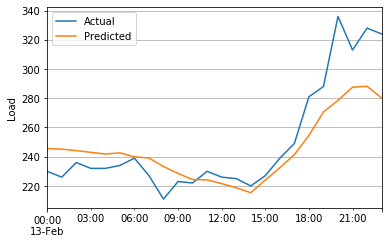

MAPE = 5.55 (%)


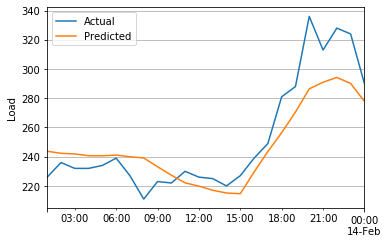

MAPE = 5.48 (%)


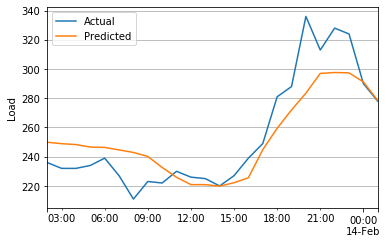

MAPE = 5.16 (%)


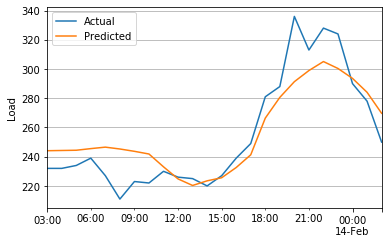

MAPE = 6.29 (%)


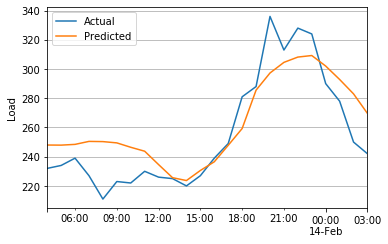

MAPE = 6.42 (%)


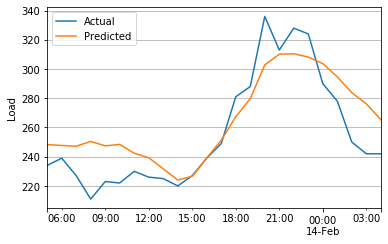

MAPE = 5.87 (%)


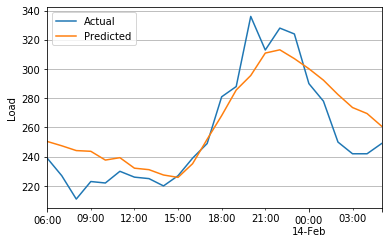

MAPE = 6.13 (%)


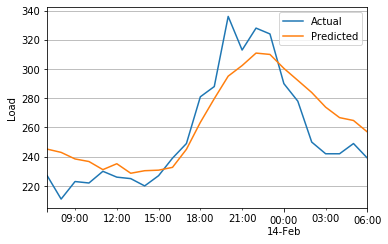

MAPE = 5.68 (%)


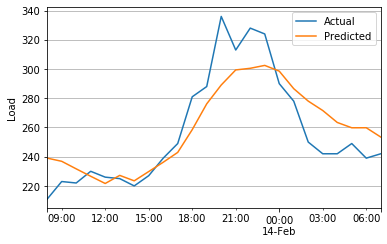

MAPE = 4.36 (%)


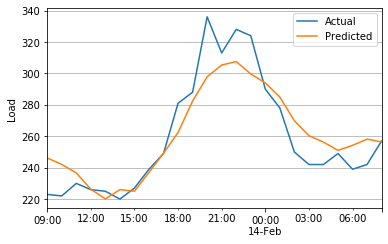

MAPE = 3.65 (%)


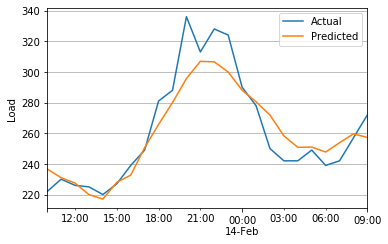

MAPE = 4.02 (%)


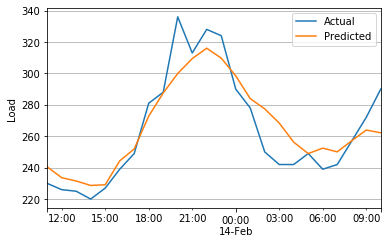

In [25]:
# Plotting multi-step ahead predictions using the walk-forward method
if TEST_SIZE == 1: 
    raise ValueError('TEST_SIZE: Need a multi-step ahead predictions!')
date_start = pd.to_datetime(START_DATE) + dt.timedelta(days=WINDOW_SIZE_DAYS)
for i in range(TEST_SIZE):
    date_end = date_start + dt.timedelta(hours=23)
    y_true = data_features['Load+0h'].loc[date_start:date_end]
    y_values = pd.DataFrame(y_true)
    y_values = y_values.rename(columns={'Load+0h':'Actual'})
    y_values['Predicted'] = y_pred[i,:]
    
    # Absolute percentage error
    y_values['APE'] = np.abs((y_values['Actual'] - y_values['Predicted'])/y_values['Actual'])*100.
    # Mean absolute percentage error
    mape = mean_absolute_percentage_error(y_values['Actual'].values, y_values['Predicted'].values)
    print('MAPE = {:.2f} (%)'.format(mape))
    
    # Plot figure
    y_values[['Actual', 'Predicted']].plot(figsize=(5.5,3.5))
    plt.ylabel('Load')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    date_start = date_start + dt.timedelta(hours=1)